In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import pickle as pkl
import sys

from sklearn.metrics import roc_curve
# Own modules
module_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.abspath(module_path))

from src.utils import description_file_utils

results_dir = os.path.join(module_path, 'datasets', 'results')

In [2]:
# Some config (do not change)

method_labels = {'unsupervised_density': 'Unsupervised density',
                 'energy_detector': 'Energy detector',
                 'one_class_svm': 'OCSVM',
                 'lof': 'LOF',
                 'dbscan': 'DBSCAN',
                 'elliptic_envelope': 'Elliptic envelope'}

method_colors = {'energy_detector': 'C0',
                 'one_class_svm': 'C1',
                 'dbscan': 'C2',
                 'lof': 'C3',
                 'elliptic_envelope': 'C4',
                 'unsupervised_density': 'C5'}

tx_inacc_std = {0: 0,
                0.37: 0.37}

dt_type_impl = {"Sionna":'Sionna',
                "ML":'ML'}

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

C:\Users\anton.krause\AppData\Local\Temp\ipykernel_12984\2221868813.py:110: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=truncated_tab20,


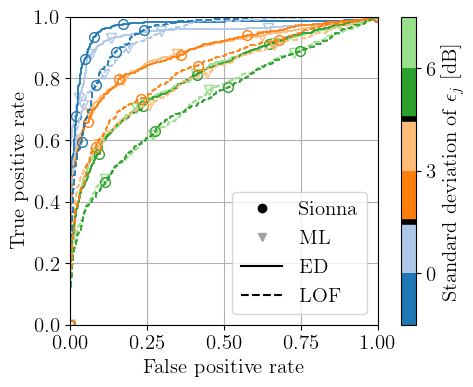

In [5]:
methods = ['unsupervised_threshold', 'lof']   # unsupervised_threshold, lof

noise_values_to_plot = [0, 3, 6]

font_size = 15

markers_by_dt_type = {'Sionna': 'o', 'ML': 'v'}
linestyle_by_algorithm = {'unsupervised_threshold': '-', 'lof': '--'}

dataset_idx_by_dt_type = {'Sionna': 1, 'ML': 2}

# Get the original tab20 colormap
tab20 = plt.cm.get_cmap('tab20')

# Define the number of colors you want to keep
num_colors = 6

# Create a new truncated colormap
new_colors = tab20(np.linspace(0, 0.29, num_colors))
truncated_tab20 = mcolors.LinearSegmentedColormap.from_list('truncated_tab20', new_colors, num_colors)


plt.rcParams['figure.figsize'] = (6, 4)
old_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = font_size

fig = plt.figure()


def get_color_for_value(dt_type, value):
    """Returns the color code for a value within a range using a specific colormap."""

    if dt_type == 'Sionna':
        if value == 0:
            norm_value = 1/12
        elif value == 3:
            norm_value = 5/12
        elif value == 6:
            norm_value = 9/12
    elif dt_type == 'ML':
        if value == 0:
            norm_value = 3/12
        elif value == 3:
            norm_value = 7/12
        elif value == 6:
            norm_value = 11/12  
    rgba_color = truncated_tab20(norm_value)

    # Convert the RGBA color code to hex
    hex_color = mcolors.to_hex(rgba_color)

    return hex_color


# Load results from file
results = {}
for dt_type in ['ML', 'Sionna']:
    with open(os.path.join(results_dir, f'sionna_{dataset_idx_by_dt_type[dt_type]}_prob.pkl'), 'rb') as f_results:
        results[dt_type] = pkl.load(f_results)


def plot_method(method):

    # Calculate and plot the ROC curve for each method
    for dt_type in ['ML', 'Sionna']:


        for noise_std in results[dt_type][method]:

            if noise_std not in noise_values_to_plot:
                continue

            if method == 'one_class_svm':
                fpr, tpr, thresholds = roc_curve(results[dt_type][method][noise_std]['y_test'],
                                                -results[dt_type][method][noise_std]['y_hat'])
            else:
                fpr, tpr, thresholds = roc_curve(results[dt_type][method][noise_std]['y_test'],
                                                results[dt_type][method][noise_std]['y_hat'])

            c = get_color_for_value(dt_type, noise_std)

            plt.plot(fpr, tpr, c, linestyle=linestyle_by_algorithm[method],
                      marker=markers_by_dt_type[dt_type], markerfacecolor='none',
                      linewidth=1.3, markersize=7,
                      markevery = np.linspace(0, len(fpr)-1, 6).astype(int)
                      )


for method in methods:
    plot_method(method)

# Add legend entries for the type of algorithm
plt.plot([], [], color='black', marker=markers_by_dt_type['Sionna'], linestyle='None', label='Sionna')
plt.plot([], [], color='#A1A1A1', marker=markers_by_dt_type['ML'], linestyle='None', label='ML')
plt.plot([], [], color='black', linestyle=linestyle_by_algorithm['unsupervised_threshold'], label='ED')
plt.plot([], [], color='black', linestyle=linestyle_by_algorithm['lof'], label='LOF')

# Plot the 50-50 line
# plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='No skill')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0, 1])
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([0, 1])
plt.grid()
# just plot the colorbar once        
noise_std_min = noise_values_to_plot[0]
noise_std_max = noise_values_to_plot[-1]
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=truncated_tab20,
                                          norm=plt.Normalize(vmin=noise_std_min, vmax=noise_std_max)))
cbar.set_label(label='Standard deviation of $\epsilon_j$ [dB]', fontsize=font_size)
cbar.ax.set_yticks(np.arange(1, 6, 2), labels=[0, 3, 6])
for separation_line in [2, 4]:
    cbar.ax.axhline(separation_line, color='black', linewidth=4)
    
plt.legend()
plt.gca().set_aspect('equal', 'box')


fig_path = os.path.join(module_path, 'figures', 'sionna_roc', 'roc_joint_oneplot.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

plt.rcParams['font.size'] = old_font_size

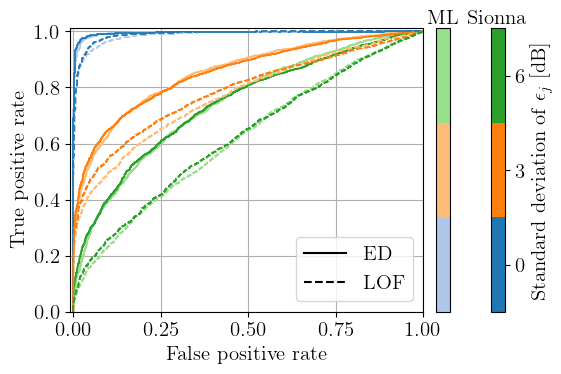

In [5]:
su_height = 5.0 # height of the SUs in meters, results available for 1.5 and 5.0 meters
methods = ['energy_detector', 'lof']   # energy_detector, lof

noise_values_to_plot = [0, 3, 6]

font_size = 15

markers_by_dt_type = {'Sionna': 'o', 'ML': 'v'}
linestyle_by_algorithm = {'energy_detector': '-', 'lof': '--'}

dataset_idx_by_dt_type = {'Sionna-1.5': 0, 'ML-1.5': 1, 'Sionna-5.0': 2, 'ML-5.0': 3}

su_height_str = f'{su_height:.1f}'

if su_height == 1.5:
    plot_colorbar = True
else:
    plot_colorbar = True

# Get the original tab20 segmented colormap with 20 colors
tab20 = plt.cm.get_cmap('tab20')

# Create two colormaps, a dark one for Sionna and a light one for ML
colors_si = []
colors_ml = []
for i in range(0, 6, 2):
    colors_si.append(tab20(i))
    colors_ml.append(tab20(i+1))
cmap_si = mcolors.ListedColormap(colors_si)
cmap_ml = mcolors.ListedColormap(colors_ml)


plt.rcParams['figure.figsize'] = (6, 4)
old_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = font_size

fig = plt.figure()


# Load results from file
results = {}
for dt_type in ['ML', 'Sionna']:
    idx_key = f'{dt_type}-{su_height_str}'
    with open(os.path.join(results_dir, f'sionna_{dataset_idx_by_dt_type[idx_key]}_prob.pkl'), 'rb') as f_results:
        results[dt_type] = pkl.load(f_results)


def plot_method(method):

    # Calculate and plot the ROC curve for each method
    for dt_type in ['ML', 'Sionna']:

        for noise_std in results[dt_type][method]:

            if noise_std not in noise_values_to_plot:
                continue


            fpr, tpr, thresholds = roc_curve(results[dt_type][method][noise_std]['y_test'],
                                            results[dt_type][method][noise_std]['y_hat'])

            if dt_type == 'Sionna':
                c = cmap_si(noise_std/6)
            elif dt_type == 'ML':
                c = cmap_ml(noise_std/6)

            plt.plot(fpr, tpr, color=c, linestyle=linestyle_by_algorithm[method],
                    #   marker=markers_by_dt_type[dt_type],
                        markerfacecolor='none',
                      linewidth=1.3, markersize=7,
                    #   markevery = np.linspace(0, len(fpr)-1, 6).astype(int)
                      )


for method in methods:
    plot_method(method)

# Add legend entries for the type of algorithm
# plt.plot([], [], color='black', marker=markers_by_dt_type['Sionna'], linestyle='None', label='Sionna')
# plt.plot([], [], color='#A1A1A1', marker=markers_by_dt_type['ML'], linestyle='None', label='ML')
plt.plot([], [], color='black', linestyle=linestyle_by_algorithm['energy_detector'], label='ED')
plt.plot([], [], color='black', linestyle=linestyle_by_algorithm['lof'], label='LOF')

# Plot the 50-50 line
# plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='No skill')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([-0.01, 1])
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([0, 1.01])
plt.grid()

if plot_colorbar:       
    noise_std_min = noise_values_to_plot[0]
    noise_std_max = noise_values_to_plot[-1]
    cbar_si = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_si,
                                                norm=plt.Normalize(vmin=noise_std_min, vmax=noise_std_max)), ax=plt.gca(), pad=-0.02)
    cbar_si.set_label(label='Standard deviation of $\epsilon_j$ [dB]', fontsize=font_size)
    cbar_si.ax.text(0.5, 6.2, 'Sionna', rotation=0, ha='center', va='center')
    cbar_si.ax.set_yticks(np.arange(1, 6, 2), labels=[0, 3, 6])

    cbar_ml = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_ml,
                                                norm=plt.Normalize(vmin=noise_std_min, vmax=noise_std_max)), ax=plt.gca(), pad=0.03)
    cbar_ml.ax.set_yticks([])
    cbar_ml.ax.text(0.5, 6.2, 'ML', rotation=0, ha='center', va='center')



plt.legend(loc='lower right')
# plt.gca().set_aspect('equal', 'box')
plt.tight_layout()


fig_path = os.path.join(module_path, 'figures', f'roc_joint_rx{su_height_str}m.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

plt.rcParams['font.size'] = old_font_size